In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit, OptimizeWarning
from tqdm import tqdm
import warnings
from scipy.stats import zscore
from statsmodels.tsa.stattools import acf, pacf
from scipy.optimize import minimize


sns.set_theme()
sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
dtype_dict = {
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'AnimalNumber': 'Int64',          
    'StartDate': 'str',
    'StartTime': 'str',
    'DateTime': 'str',
    'LactationNumber': 'Int64',       
    'DaysInMilk': 'Int64', 
    'YearSeason': 'str',           
    'TotalYield': 'float',
    'DateTime': 'str',
    'BreedName': 'str',
    'Age': 'Int64',
    'Mother': 'str',
    'Father': 'str',
    'CullDecisionDate': 'str',
    'Temperature2': 'float',
    'RelativeHumidity': 'float',      
    'THI_adj2': 'float',
    'HW': 'Int64',                    
    'cum_HW': 'Int64',                
    'Temp15Threshold': 'Int64'        
}

# Load the CSV with specified dtypes
data = pd.read_csv('../Data/MergedData/CleanedYieldData.csv', dtype=dtype_dict)
# data = pd.read_csv('../Data/MergedData/YieldData.csv', dtype=dtype_dict)
# data = data[data["DaysInMilk"].notna()]

# Convert date and time columns back to datetime and time objects
data['DateTime'] = pd.to_datetime(data['DateTime'], errors='coerce')
data['StartTime'] = pd.to_datetime(data['StartTime'], format='%H:%M:%S', errors='coerce').dt.time
data['StartDate'] = pd.to_datetime(data['StartDate'], errors='coerce')
data['CullDecisionDate'] = pd.to_datetime(data['CullDecisionDate'], errors='coerce')
data['DateTime'] = pd.to_datetime(data['DateTime'], errors='coerce')
data.head()

,FarmName_Pseudo,SE_Number,AnimalNumber,StartDate,StartTime,LactationNumber,DaysInMilk,YearSeason,TotalYield,DateTime,...,Mother,Father,CullDecisionDate,Temperature2,RelativeHumidity,THI_adj2,HW,cum_HW,Temp15Threshold,Age
0,5b581702,SE-27c3257a-1492,1492,2022-11-25,07:13:00,1,32,202204,18.57,2022-11-25 07:13:00,...,SE-27c3257a-1355,SE-458cc45c-7488,NaT,1.2,0.968,35.70600,0,0,0,773
1,5b581702,SE-27c3257a-1492,1492,2022-11-25,14:13:00,1,32,202204,9.73,2022-11-25 14:13:00,...,SE-27c3257a-1355,SE-458cc45c-7488,NaT,1.7,0.971,38.17406,0,0,0,773
2,5b581702,SE-27c3257a-1492,1492,2022-11-25,23:02:00,1,32,202204,11.30,2022-11-25 23:02:00,...,SE-27c3257a-1355,SE-458cc45c-7488,NaT,1.6,0.982,37.82760,0,0,0,773
3,5b581702,SE-27c3257a-1492,1492,2022-11-26,08:01:00,1,33,202204,12.78,2022-11-26 08:01:00,...,SE-27c3257a-1355,SE-458cc45c-7488,NaT,1.6,0.979,36.56612,0,0,0,774
4,5b581702,SE-27c3257a-1492,1492,2022-11-26,14:53:00,1,33,202204,9.41,2022-11-26 14:53:00,...,SE-27c3257a-1355,SE-458cc45c-7488,NaT,1.3,0.976,37.17240,0,0,0,774


In [13]:
# Calculate the DailyYield for each cow each day
data['DailyYield'] = data.groupby(['SE_Number', 'StartDate'])['TotalYield'].transform('sum')

# Sort the data by AnimalNumber and StartDate
data.sort_values(['AnimalNumber', 'StartDate'], inplace=True)

# Calculate the previous day's total yield for each cow
data['PreviousDailyYield'] = data.groupby('AnimalNumber')['DailyYield'].shift(1)

# Calculate the daily yield change for each cow
data['DailyYieldChange'] = data['DailyYield'] - data['PreviousDailyYield']

# Group and aggregate data ===========================================================>>> OBS change Temperature to Temperature2 and THI_adj to THI_adj2 when running filtered data
data = data.groupby(['SE_Number', 'FarmName_Pseudo', 'StartDate']).agg({
    'DailyYield': 'first',
    'PreviousDailyYield': 'first',
    'DailyYieldChange': 'first',
    'HW': 'max',
    'Temperature2': 'mean',
    'THI_adj2': 'mean',
    'DaysInMilk': 'first',
    'YearSeason': 'first',
    'cum_HW': 'max',
    'Temp15Threshold': 'max',
    'Age': 'first',
    'BreedName': 'first',
    'LactationNumber': 'first'
}).reset_index()

# Renaming and formatting ===========================================================>>> OBS change Temperature to Temperature2 and THI_adj to THI_adj2 when running filtered data
data.rename(columns={
    'Temperature2': 'MeanTemperature',
    'THI_adj2': 'MeanTHI_adj',
    'StartDate': 'Date'
}, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

# Display the first few rows of the transformed data
data.head()

,SE_Number,FarmName_Pseudo,Date,DailyYield,PreviousDailyYield,DailyYieldChange,HW,MeanTemperature,MeanTHI_adj,DaysInMilk,YearSeason,cum_HW,Temp15Threshold,Age,BreedName,LactationNumber
0,SE-27c3257a-1492,5b581702,2022-11-25,39.60,39.60,0.00,0,1.50,37.235887,32,202204,0,0,773,DairyCross,1
1,SE-27c3257a-1492,5b581702,2022-11-26,22.19,39.60,-17.41,0,1.45,36.869260,33,202204,0,0,774,DairyCross,1
2,SE-27c3257a-1492,5b581702,2022-11-27,29.40,22.19,7.21,0,-0.15,30.678900,34,202204,0,0,775,DairyCross,1
3,SE-27c3257a-1492,5b581702,2022-11-28,27.03,29.40,-2.37,0,2.70,37.007500,35,202204,0,0,776,DairyCross,1
4,SE-27c3257a-1492,5b581702,2022-11-29,26.88,27.03,-0.15,0,2.85,38.536020,36,202204,0,0,777,DairyCross,1


In [14]:
# Check if DailyYield is centered around approx the same for each farm 
print("Mean of DailyYield:", data.groupby('FarmName_Pseudo')['DailyYield'].mean())
print("Standard Deviation of DailyYield:", data.groupby('FarmName_Pseudo')['DailyYield'].std())

Mean of DailyYield: FarmName_Pseudo
5b581702    35.678012
5c06d92d    37.452461
6d38bc90    13.700241
a624fb9a    34.210868
a756bc39    35.051945
ad0a39f5    39.726063
f454e660    31.359891
Name: DailyYield, dtype: float64
Standard Deviation of DailyYield: FarmName_Pseudo
5b581702    11.797328
5c06d92d     9.368416
6d38bc90     4.865680
a624fb9a    10.963657
a756bc39    12.326717
ad0a39f5     9.542836
f454e660    11.422065
Name: DailyYield, dtype: float64


## Wilmink Lactation Curve
$$
Y(t) = a + bt + c \exp(-dt)
$$
- \(Y(t)\): Milk yield at time \(t\) post-calving, so t = DaysInMilk
- \(a\): Intercept, representing baseline milk yield
- \(b\): Linear increase rate of milk yield over time
- \(c\): Initial exponential increase in milk yield
- \(d\): Rate at which the exponential increase declines over time

The Wilmink model captures the lactation curve by considering both linear and exponential components, providing a flexible representation of milk production dynamics over the lactation period.

In [15]:
# Define the Wilmink Lactation Curve function
def wilmink_lactation_curve(dim, a, b, c, d):
    dim = np.array(dim, dtype=float)
    return a + b * dim + c * np.exp(-d * dim)

# Function to detect and remove outliers
def remove_outliers(group, threshold=3.5):
    mean = np.mean(group['DailyYield'])
    std_dev = np.std(group['DailyYield'])
    return group[(group['DailyYield'] > mean - threshold * std_dev) & (group['DailyYield'] < mean + threshold * std_dev)]

# Function to smooth the data using a rolling average
def smooth_data(group, window=5):
    group = group.copy()
    group['DailyYield'] = group['DailyYield'].rolling(window, min_periods=1).mean()
    return group

# Function to fit the Wilmink Lactation Curve to the dataset
def fit_wilmink_lactation_curve(dataset):
    # Initialize the 'ExpectedYield' column to NaN
    dataset['ExpectedYield'] = np.nan
    params_dict = {}
    
    valid_indices = []

    # Group the dataset by 'SE_Number' and 'LactationNumber' and fit the curve for each segment
    for (animal_number, lactation_number), group in tqdm(dataset.groupby(['SE_Number', 'LactationNumber']), unit=" Segments"):
        # Prepare the data for fitting
        group = remove_outliers(group, threshold=3.5)  # Remove outliers with threshold 4
        group = smooth_data(group)  # Smooth the data
        x_data = group['DaysInMilk'].values
        y_data = group['DailyYield'].values
        
        # Ensure there are no NaN or infinite values in the data
        if not np.isfinite(x_data).all() or not np.isfinite(y_data).all():
            print(f"Non-finite values found for cow {animal_number}, lactation {lactation_number}, skipping.")
            continue
        
        # Ensure there are enough data points to fit the curve
        if len(x_data) < 150 or len(y_data) < 150:
            print(f"Insufficient data points for cow {animal_number}, lactation {lactation_number}, skipping.")
            continue

        valid_indices.extend(group.index)
        
        # Fit the model
        try:
            # Initial parameter guesses
            initial_guesses = [np.mean(y_data), 0, np.mean(y_data) / 2, 0.1]
            # Bounds on the parameters to prevent overflow
            bounds = ([-np.inf, -np.inf, -np.inf, 0], [np.inf, np.inf, np.inf, np.inf])
            
            with warnings.catch_warnings():
                warnings.filterwarnings('error', category=OptimizeWarning)
                try:
                    popt, pcov = curve_fit(
                        wilmink_lactation_curve, x_data, y_data,
                        p0=initial_guesses, bounds=bounds, maxfev=30000
                    )
                    
                    # Store the parameters in the dictionary
                    params_dict[(animal_number, lactation_number)] = {'a': popt[0], 'b': popt[1], 'c': popt[2], 'd': popt[3]}
                    
                    # Predict the expected yield using the fitted model
                    dataset.loc[group.index, 'ExpectedYield'] = wilmink_lactation_curve(group['DaysInMilk'], *popt)
                
                except OptimizeWarning:
                    print(f"OptimizeWarning for cow {animal_number}, lactation {lactation_number}, skipping.")
            
        except RuntimeError as e:
            print(f"Curve fit failed for cow {animal_number}, lactation {lactation_number}: {e}")
        except ValueError as e:
            print(f"Value error for cow {animal_number}, lactation {lactation_number}: {e}")
    
    # Keep only valid indices
    dataset = dataset.loc[valid_indices].reset_index(drop=True)
    
    return dataset, params_dict

# Apply the curve fitting function to your dataset
data, params_dict = fit_wilmink_lactation_curve(data)

# Remove rows where ExpectedYield is NaN
data = data.dropna(subset=['ExpectedYield'])

# Calculate NormalizedDailyYield, PreviousDailyYield, DailyYieldChange, and NormalizedDailyYieldChange
data.loc[:, 'NormalizedDailyYield'] = data['DailyYield'] / data['ExpectedYield']
data.loc[:, 'PreviousDailyYield'] = data.groupby('SE_Number')['DailyYield'].shift(1)
data.loc[:, 'DailyYieldChange'] = data['DailyYield'] - data['PreviousDailyYield']
data.loc[:, 'NormalizedDailyYieldChange'] = data['DailyYieldChange'] / data['ExpectedYield']

data

  2%|▏         | 24/1207 [00:06<03:04,  6.40 Segments/s]

Insufficient data points for cow SE-5b581702-1912, lactation 3, skipping.


  3%|▎         | 41/1207 [00:09<03:03,  6.37 Segments/s]

Insufficient data points for cow SE-5b581702-2002, lactation 3, skipping.


 10%|█         | 123/1207 [00:14<00:27, 39.61 Segments/s]

Insufficient data points for cow SE-5c06d92d-2744, lactation 4, skipping.
Insufficient data points for cow SE-5c06d92d-2762, lactation 5, skipping.
Insufficient data points for cow SE-5c06d92d-2782, lactation 5, skipping.


 14%|█▍        | 167/1207 [00:14<00:16, 63.11 Segments/s]

Insufficient data points for cow SE-5c06d92d-2866, lactation 4, skipping.
Insufficient data points for cow SE-5c06d92d-2941, lactation 3, skipping.


 18%|█▊        | 213/1207 [00:17<00:53, 18.69 Segments/s]

Insufficient data points for cow SE-5c06d92d-3017, lactation 4, skipping.


 22%|██▏       | 261/1207 [00:21<00:42, 22.20 Segments/s]

Insufficient data points for cow SE-5c06d92d-3054, lactation 3, skipping.
Insufficient data points for cow SE-5c06d92d-3076, lactation 4, skipping.
Insufficient data points for cow SE-5c06d92d-3106, lactation 4, skipping.


 28%|██▊       | 337/1207 [00:26<00:58, 14.92 Segments/s]

Insufficient data points for cow SE-5c06d92d-3176, lactation 3, skipping.


 33%|███▎      | 393/1207 [00:27<00:14, 56.27 Segments/s]

Insufficient data points for cow SE-5c06d92d-3226, lactation 3, skipping.


 35%|███▍      | 417/1207 [00:27<00:12, 63.39 Segments/s]

Insufficient data points for cow SE-5c06d92d-3266, lactation 2, skipping.


 37%|███▋      | 452/1207 [00:27<00:08, 90.21 Segments/s]

Insufficient data points for cow SE-5c06d92d-3292, lactation 1, skipping.


 39%|███▉      | 476/1207 [00:27<00:07, 100.18 Segments/s]

Insufficient data points for cow SE-5c06d92d-3330, lactation 2, skipping.


 43%|████▎     | 515/1207 [00:28<00:05, 117.65 Segments/s]

Insufficient data points for cow SE-5c06d92d-3377, lactation 2, skipping.
Insufficient data points for cow SE-5c06d92d-3403, lactation 2, skipping.
Insufficient data points for cow SE-5c06d92d-3404, lactation 2, skipping.


 45%|████▍     | 540/1207 [00:28<00:06, 106.24 Segments/s]

Insufficient data points for cow SE-5c06d92d-3427, lactation 2, skipping.


 52%|█████▏    | 623/1207 [00:29<00:05, 110.50 Segments/s]

Insufficient data points for cow SE-5c06d92d-3589, lactation 1, skipping.
Insufficient data points for cow SE-5c06d92d-3593, lactation 1, skipping.
Insufficient data points for cow SE-5c06d92d-3594, lactation 1, skipping.
Insufficient data points for cow SE-5c06d92d-3599, lactation 1, skipping.
Insufficient data points for cow SE-5c06d92d-3601, lactation 1, skipping.
Insufficient data points for cow SE-5c06d92d-3602, lactation 1, skipping.
Insufficient data points for cow SE-5c06d92d-3605, lactation 1, skipping.
Insufficient data points for cow SE-5c06d92d-3607, lactation 1, skipping.
Insufficient data points for cow SE-61d8a0fa-0972, lactation 5, skipping.
Insufficient data points for cow SE-6d38bc90-2373, lactation 5, skipping.
Insufficient data points for cow SE-6d38bc90-2592, lactation 3, skipping.
Insufficient data points for cow SE-6d38bc90-2869, lactation 2, skipping.
Insufficient data points for cow SE-6d38bc90-2923, lactation 2, skipping.
Insufficient data points for cow SE-6d

 54%|█████▎    | 647/1207 [00:32<00:28, 19.47 Segments/s] 

Insufficient data points for cow SE-a624fb9a-1275, lactation 5, skipping.
Insufficient data points for cow SE-a624fb9a-1287, lactation 5, skipping.


 56%|█████▋    | 679/1207 [00:36<00:47, 11.15 Segments/s]

Insufficient data points for cow SE-a624fb9a-1322, lactation 4, skipping.
Insufficient data points for cow SE-a624fb9a-1330, lactation 5, skipping.


 58%|█████▊    | 700/1207 [00:39<00:44, 11.27 Segments/s]

Insufficient data points for cow SE-a624fb9a-1342, lactation 4, skipping.
Insufficient data points for cow SE-a624fb9a-1348, lactation 3, skipping.


 68%|██████▊   | 824/1207 [00:46<00:08, 46.70 Segments/s]

Insufficient data points for cow SE-a624fb9a-1521, lactation 1, skipping.
Insufficient data points for cow SE-a756bc39-0884, lactation 7, skipping.
Insufficient data points for cow SE-a756bc39-0894, lactation 6, skipping.
Insufficient data points for cow SE-a756bc39-0975, lactation 5, skipping.
Insufficient data points for cow SE-a756bc39-0986, lactation 5, skipping.
Insufficient data points for cow SE-a756bc39-0999, lactation 5, skipping.
Insufficient data points for cow SE-a756bc39-1024, lactation 4, skipping.


 71%|███████   | 852/1207 [00:47<00:04, 72.69 Segments/s]

Insufficient data points for cow SE-a756bc39-1070, lactation 4, skipping.
Insufficient data points for cow SE-a756bc39-1112, lactation 3, skipping.
Insufficient data points for cow SE-a756bc39-1127, lactation 3, skipping.
Insufficient data points for cow SE-a756bc39-1129, lactation 3, skipping.
Insufficient data points for cow SE-a756bc39-1135, lactation 3, skipping.
Insufficient data points for cow SE-a756bc39-1154, lactation 3, skipping.


 72%|███████▏  | 865/1207 [00:49<00:21, 16.03 Segments/s]

Insufficient data points for cow SE-a756bc39-1157, lactation 3, skipping.
Insufficient data points for cow SE-a756bc39-1159, lactation 3, skipping.
Insufficient data points for cow SE-a756bc39-1162, lactation 3, skipping.
Insufficient data points for cow SE-a756bc39-1195, lactation 3, skipping.
Insufficient data points for cow SE-a756bc39-1206, lactation 3, skipping.


 74%|███████▎  | 889/1207 [00:49<00:11, 27.41 Segments/s]

Insufficient data points for cow SE-a756bc39-1207, lactation 2, skipping.
Insufficient data points for cow SE-a756bc39-1222, lactation 2, skipping.
Insufficient data points for cow SE-a756bc39-1224, lactation 2, skipping.
Insufficient data points for cow SE-a756bc39-1226, lactation 2, skipping.
Insufficient data points for cow SE-a756bc39-1230, lactation 2, skipping.
Insufficient data points for cow SE-a756bc39-1231, lactation 2, skipping.
Insufficient data points for cow SE-a756bc39-1252, lactation 2, skipping.


 75%|███████▍  | 901/1207 [00:49<00:08, 34.93 Segments/s]

Insufficient data points for cow SE-a756bc39-1264, lactation 1, skipping.
Insufficient data points for cow SE-a756bc39-1268, lactation 1, skipping.
Insufficient data points for cow SE-a756bc39-1275, lactation 1, skipping.
Insufficient data points for cow SE-a756bc39-1276, lactation 1, skipping.
Insufficient data points for cow SE-a756bc39-1284, lactation 1, skipping.
Insufficient data points for cow SE-a756bc39-1285, lactation 1, skipping.
Insufficient data points for cow SE-a756bc39-1288, lactation 1, skipping.


 78%|███████▊  | 947/1207 [00:52<00:09, 28.02 Segments/s]

Insufficient data points for cow SE-ad0a39f5-2139, lactation 5, skipping.
Insufficient data points for cow SE-ad0a39f5-2147, lactation 5, skipping.
Insufficient data points for cow SE-ad0a39f5-2176, lactation 4, skipping.
Insufficient data points for cow SE-ad0a39f5-2230, lactation 4, skipping.
Insufficient data points for cow SE-ad0a39f5-2280, lactation 4, skipping.
Insufficient data points for cow SE-ad0a39f5-2282, lactation 3, skipping.
Insufficient data points for cow SE-ad0a39f5-2283, lactation 4, skipping.
Insufficient data points for cow SE-ad0a39f5-2288, lactation 4, skipping.
Insufficient data points for cow SE-ad0a39f5-2295, lactation 4, skipping.
Insufficient data points for cow SE-ad0a39f5-2321, lactation 4, skipping.


 79%|███████▉  | 959/1207 [00:54<00:17, 14.04 Segments/s]

Insufficient data points for cow SE-ad0a39f5-2339, lactation 4, skipping.
Insufficient data points for cow SE-ad0a39f5-2346, lactation 3, skipping.
Insufficient data points for cow SE-ad0a39f5-2349, lactation 4, skipping.


 82%|████████▏ | 984/1207 [00:57<00:18, 12.11 Segments/s]

Insufficient data points for cow SE-ad0a39f5-2392, lactation 4, skipping.
Insufficient data points for cow SE-ad0a39f5-2420, lactation 3, skipping.
Insufficient data points for cow SE-ad0a39f5-2438, lactation 3, skipping.


 84%|████████▍ | 1019/1207 [01:04<00:20,  9.08 Segments/s]

Insufficient data points for cow SE-ad0a39f5-2533, lactation 2, skipping.
Insufficient data points for cow SE-ad0a39f5-2537, lactation 3, skipping.
Insufficient data points for cow SE-ad0a39f5-2548, lactation 3, skipping.
Insufficient data points for cow SE-ad0a39f5-2576, lactation 2, skipping.
Insufficient data points for cow SE-ad0a39f5-2580, lactation 2, skipping.
Insufficient data points for cow SE-ad0a39f5-2599, lactation 2, skipping.
Insufficient data points for cow SE-ad0a39f5-2621, lactation 2, skipping.
Insufficient data points for cow SE-ad0a39f5-2625, lactation 2, skipping.


 86%|████████▌ | 1034/1207 [01:04<00:13, 13.24 Segments/s]

Insufficient data points for cow SE-ad0a39f5-2628, lactation 2, skipping.
Insufficient data points for cow SE-ad0a39f5-2629, lactation 2, skipping.
Insufficient data points for cow SE-ad0a39f5-2642, lactation 2, skipping.
Insufficient data points for cow SE-ad0a39f5-2643, lactation 2, skipping.
Insufficient data points for cow SE-ad0a39f5-2644, lactation 2, skipping.
Insufficient data points for cow SE-ad0a39f5-2647, lactation 2, skipping.
Insufficient data points for cow SE-ad0a39f5-2653, lactation 2, skipping.
Insufficient data points for cow SE-ad0a39f5-2654, lactation 2, skipping.
Insufficient data points for cow SE-ad0a39f5-2657, lactation 2, skipping.


 88%|████████▊ | 1066/1207 [01:07<00:09, 14.83 Segments/s]

Insufficient data points for cow SE-ad0a39f5-2664, lactation 2, skipping.
Insufficient data points for cow SE-ad0a39f5-2668, lactation 2, skipping.
Insufficient data points for cow SE-ad0a39f5-2676, lactation 2, skipping.
Insufficient data points for cow SE-ad0a39f5-2677, lactation 2, skipping.


 91%|█████████ | 1095/1207 [01:07<00:03, 31.38 Segments/s]

Insufficient data points for cow SE-ad0a39f5-2710, lactation 2, skipping.
Insufficient data points for cow SE-ad0a39f5-2734, lactation 1, skipping.


 92%|█████████▏| 1114/1207 [01:07<00:02, 42.44 Segments/s]

Insufficient data points for cow SE-ad0a39f5-2765, lactation 1, skipping.
Insufficient data points for cow SE-ad0a39f5-2768, lactation 1, skipping.
Insufficient data points for cow SE-ad0a39f5-2781, lactation 1, skipping.
Insufficient data points for cow SE-ad0a39f5-2787, lactation 1, skipping.
Insufficient data points for cow SE-ad0a39f5-2790, lactation 1, skipping.
Insufficient data points for cow SE-ad0a39f5-2792, lactation 1, skipping.
Insufficient data points for cow SE-ad0a39f5-2795, lactation 1, skipping.
Insufficient data points for cow SE-ad0a39f5-2797, lactation 1, skipping.
Insufficient data points for cow SE-ad0a39f5-2806, lactation 1, skipping.
Insufficient data points for cow SE-ad0a39f5-2807, lactation 1, skipping.
Insufficient data points for cow SE-ad0a39f5-2810, lactation 1, skipping.
Insufficient data points for cow SE-ad0a39f5-2811, lactation 1, skipping.
Insufficient data points for cow SE-ad0a39f5-2813, lactation 1, skipping.
Insufficient data points for cow SE-ad

100%|██████████| 1207/1207 [01:23<00:00, 14.45 Segments/s]


,SE_Number,FarmName_Pseudo,Date,DailyYield,PreviousDailyYield,DailyYieldChange,HW,MeanTemperature,MeanTHI_adj,DaysInMilk,YearSeason,cum_HW,Temp15Threshold,Age,BreedName,LactationNumber,ExpectedYield,NormalizedDailyYield,NormalizedDailyYieldChange
0,SE-27c3257a-1492,5b581702,2022-11-25,39.60,NaN,NaN,0,1.500000,37.235887,32,202204,0,0,773,DairyCross,1,28.797526,1.375118,NaN
1,SE-27c3257a-1492,5b581702,2022-11-26,22.19,39.60,-17.41,0,1.450000,36.869260,33,202204,0,0,774,DairyCross,1,28.846365,0.769248,-0.603542
2,SE-27c3257a-1492,5b581702,2022-11-27,29.40,22.19,7.21,0,-0.150000,30.678900,34,202204,0,0,775,DairyCross,1,28.894755,1.017486,0.249526
3,SE-27c3257a-1492,5b581702,2022-11-28,27.03,29.40,-2.37,0,2.700000,37.007500,35,202204,0,0,776,DairyCross,1,28.942694,0.933914,-0.081886
4,SE-27c3257a-1492,5b581702,2022-11-29,26.88,27.03,-0.15,0,2.850000,38.536020,36,202204,0,0,777,DairyCross,1,28.990182,0.927210,-0.005174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297966,SE-f454e660-0829,f454e660,2024-08-14,31.69,30.01,1.68,0,17.325000,64.076020,284,202403,0,1,939,SLB,1,26.688511,1.187402,0.062948
297967,SE-f454e660-0829,f454e660,2024-08-15,26.34,31.69,-5.35,0,21.066667,65.716753,285,202403,0,1,940,SLB,1,26.654367,0.988206,-0.200718
297968,SE-f454e660-0829,f454e660,2024-08-16,24.10,26.34,-2.24,0,19.966667,64.264293,286,202403,0,1,941,SLB,1,26.620222,0.905327,-0.084147
297969,SE-f454e660-0829,f454e660,2024-08-17,25.73,24.10,1.63,0,16.333333,60.634800,287,202403,0,1,942,SLB,1,26.586076,0.967800,0.061310


# For plotting actual vs expected milk yield with THI

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [17]:
SE_Number = ["SE-5c06d92d-3205"] # ["SE-5c06d92d-3183"] # ["SE-5b581702-1927"] # ["SE-a66dc90e-1614"]
cow_data = data[data["SE_Number"].isin(SE_Number)]

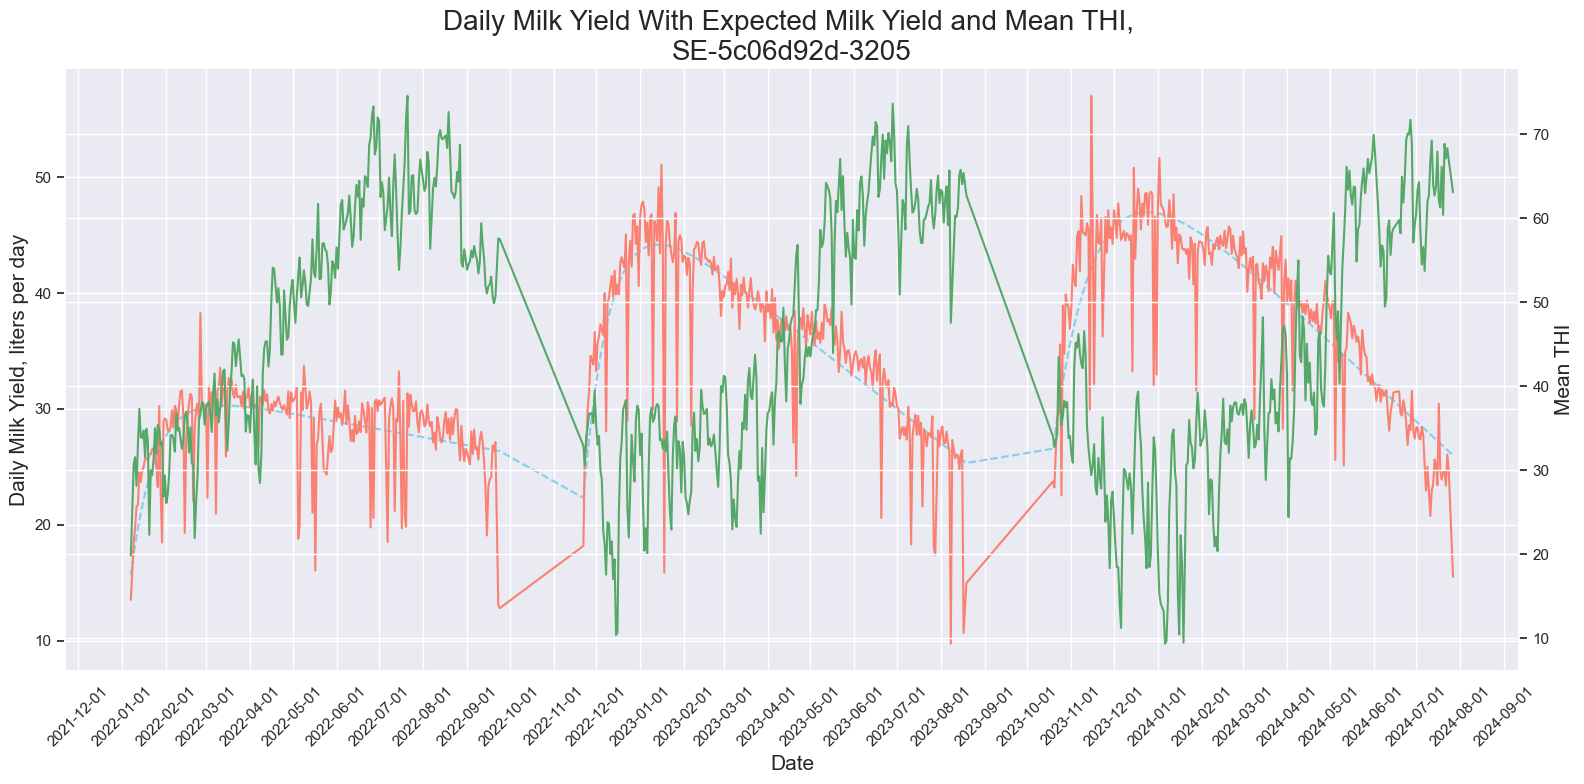

In [18]:
# MY x MEANTHI

# cow_data=data2.copy()
cow_data = cow_data.sort_values(by='Date')

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot the first y-axis (Milk Yield)
ax1.plot(cow_data['Date'], cow_data['ExpectedYield'],
         label='Expected Milk Yield per Cow', color='skyblue', linestyle='--')
ax1.plot(cow_data['Date'], cow_data['DailyYield'],
         label='Actual Milk Yield per Cow', color='salmon', linestyle='-', markersize=1)

ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Daily Milk Yield, liters per day', fontsize=15)
ax1.tick_params(axis='y')
plt.xticks(rotation=45)
plt.title('Daily Milk Yield With Expected Milk Yield and Mean THI, \nSE-5c06d92d-3205', fontsize=20)
# plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx() # instantiate a second Axes that shares the same x-axis
ax2.plot(cow_data['Date'], cow_data['MeanTHI_adj'], color='g')
ax2.set_ylabel('Mean THI', fontsize=15)
ax2.tick_params(axis='y')

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()


# Continue with Wilminks program

In [19]:
# Check if NormalizedDailyYield is centered around 1 for each unique farm
print("Mean of NormalizedDailyYield:", data.groupby('FarmName_Pseudo')['NormalizedDailyYield'].mean())
print("Standard Deviation of NormalizedDailyYield:", data.groupby('FarmName_Pseudo')['NormalizedDailyYield'].std())

Mean of NormalizedDailyYield: FarmName_Pseudo
5b581702    1.000839
5c06d92d    1.000274
a624fb9a    0.999521
ad0a39f5    1.000240
f454e660    0.999544
Name: NormalizedDailyYield, dtype: float64
Standard Deviation of NormalizedDailyYield: FarmName_Pseudo
5b581702    0.184250
5c06d92d    0.390772
a624fb9a    0.184864
ad0a39f5    0.092013
f454e660    0.221649
Name: NormalizedDailyYield, dtype: float64


In [20]:
# Define the THI threshold
THI_THRESHOLD = 61

# Calculate the daily heat load based on the THI threshold
data['HeatLoad'] = data['MeanTHI_adj'].apply(lambda x: x - THI_THRESHOLD if x > THI_THRESHOLD else -(THI_THRESHOLD - x))

# Initialize the cumulative heat load column with float type
data['CumulativeHeatLoad'] = 0.0  # Explicitly set as float

# Iterate through the data to calculate cumulative heat load correctly
for i in range(1, len(data)):
    previous_cumulative = data.at[i-1, 'CumulativeHeatLoad']
    current_heat_load = data.at[i, 'HeatLoad']
    
    if current_heat_load < 0:  # If current heat load is negative
        new_cumulative = previous_cumulative + 2 * current_heat_load
    else:
        new_cumulative = previous_cumulative + current_heat_load
    
    # Ensure the cumulative heat load never goes below zero
    if new_cumulative > 0:
        data.at[i, 'CumulativeHeatLoad'] = new_cumulative
    else:
        data.at[i, 'CumulativeHeatLoad'] = 0.0  # Ensure float is maintained

data.head(-5)

,SE_Number,FarmName_Pseudo,Date,DailyYield,PreviousDailyYield,DailyYieldChange,HW,MeanTemperature,MeanTHI_adj,DaysInMilk,...,cum_HW,Temp15Threshold,Age,BreedName,LactationNumber,ExpectedYield,NormalizedDailyYield,NormalizedDailyYieldChange,HeatLoad,CumulativeHeatLoad
0,SE-27c3257a-1492,5b581702,2022-11-25,39.60,NaN,NaN,0,1.500000,37.235887,32,...,0,0,773,DairyCross,1,28.797526,1.375118,NaN,-23.764113,0.000000
1,SE-27c3257a-1492,5b581702,2022-11-26,22.19,39.60,-17.41,0,1.450000,36.869260,33,...,0,0,774,DairyCross,1,28.846365,0.769248,-0.603542,-24.130740,0.000000
2,SE-27c3257a-1492,5b581702,2022-11-27,29.40,22.19,7.21,0,-0.150000,30.678900,34,...,0,0,775,DairyCross,1,28.894755,1.017486,0.249526,-30.321100,0.000000
3,SE-27c3257a-1492,5b581702,2022-11-28,27.03,29.40,-2.37,0,2.700000,37.007500,35,...,0,0,776,DairyCross,1,28.942694,0.933914,-0.081886,-23.992500,0.000000
4,SE-27c3257a-1492,5b581702,2022-11-29,26.88,27.03,-0.15,0,2.850000,38.536020,36,...,0,0,777,DairyCross,1,28.990182,0.927210,-0.005174,-22.463980,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297961,SE-f454e660-0829,f454e660,2024-08-09,23.96,32.13,-8.17,0,19.066667,64.864167,279,...,0,1,934,SLB,1,26.859217,0.892059,-0.304179,3.864167,85.509565
297962,SE-f454e660-0829,f454e660,2024-08-10,24.37,23.96,0.41,0,18.466667,54.884093,280,...,0,1,935,SLB,1,26.825078,0.908478,0.015284,-6.115907,73.277752
297963,SE-f454e660-0829,f454e660,2024-08-11,26.92,24.37,2.55,0,17.933333,55.203273,281,...,0,1,936,SLB,1,26.790938,1.004817,0.095181,-5.796727,61.684298
297964,SE-f454e660-0829,f454e660,2024-08-12,23.94,26.92,-2.98,0,17.166667,58.966293,282,...,0,1,937,SLB,1,26.756797,0.894726,-0.111374,-2.033707,57.616885


In [21]:
# When CumulativeHeatLoad is greater than 3, it indicates that the cow is under heat stress
data['HeatStress'] = (data['CumulativeHeatLoad'] > 3).astype(int)
data.head(-5)

,SE_Number,FarmName_Pseudo,Date,DailyYield,PreviousDailyYield,DailyYieldChange,HW,MeanTemperature,MeanTHI_adj,DaysInMilk,...,Temp15Threshold,Age,BreedName,LactationNumber,ExpectedYield,NormalizedDailyYield,NormalizedDailyYieldChange,HeatLoad,CumulativeHeatLoad,HeatStress
0,SE-27c3257a-1492,5b581702,2022-11-25,39.60,NaN,NaN,0,1.500000,37.235887,32,...,0,773,DairyCross,1,28.797526,1.375118,NaN,-23.764113,0.000000,0
1,SE-27c3257a-1492,5b581702,2022-11-26,22.19,39.60,-17.41,0,1.450000,36.869260,33,...,0,774,DairyCross,1,28.846365,0.769248,-0.603542,-24.130740,0.000000,0
2,SE-27c3257a-1492,5b581702,2022-11-27,29.40,22.19,7.21,0,-0.150000,30.678900,34,...,0,775,DairyCross,1,28.894755,1.017486,0.249526,-30.321100,0.000000,0
3,SE-27c3257a-1492,5b581702,2022-11-28,27.03,29.40,-2.37,0,2.700000,37.007500,35,...,0,776,DairyCross,1,28.942694,0.933914,-0.081886,-23.992500,0.000000,0
4,SE-27c3257a-1492,5b581702,2022-11-29,26.88,27.03,-0.15,0,2.850000,38.536020,36,...,0,777,DairyCross,1,28.990182,0.927210,-0.005174,-22.463980,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297961,SE-f454e660-0829,f454e660,2024-08-09,23.96,32.13,-8.17,0,19.066667,64.864167,279,...,1,934,SLB,1,26.859217,0.892059,-0.304179,3.864167,85.509565,1
297962,SE-f454e660-0829,f454e660,2024-08-10,24.37,23.96,0.41,0,18.466667,54.884093,280,...,1,935,SLB,1,26.825078,0.908478,0.015284,-6.115907,73.277752,1
297963,SE-f454e660-0829,f454e660,2024-08-11,26.92,24.37,2.55,0,17.933333,55.203273,281,...,1,936,SLB,1,26.790938,1.004817,0.095181,-5.796727,61.684298,1
297964,SE-f454e660-0829,f454e660,2024-08-12,23.94,26.92,-2.98,0,17.166667,58.966293,282,...,1,937,SLB,1,26.756797,0.894726,-0.111374,-2.033707,57.616885,1


In [22]:
# Make a dataframe from the parameters dictionary, it should contain Se_Number, LactationNumber, a, b, c, d
params_df = pd.DataFrame(params_dict).T.reset_index()
params_df.columns = ['SE_Number', 'LactationNumber', 'a', 'b', 'c', 'd']
params_df.head(-5)

,SE_Number,LactationNumber,a,b,c,d
0,SE-27c3257a-1492,1,267139.115240,-10.912059,-267112.118491,0.000041
1,SE-27c3257a-1492,2,54.077576,-0.104492,-35.747867,0.056055
2,SE-30dc5787-1389,6,52.976897,-0.084467,-35.568237,0.092046
3,SE-4b8091ac-1472,1,297887.949195,-11.054339,-297858.321835,0.000037
4,SE-5b581702-1742,3,50.971971,-0.067401,-43.420567,0.092601
...,...,...,...,...,...,...
1064,SE-f454e660-0791,1,23.821186,0.009026,12.328170,9.801352
1065,SE-f454e660-0793,1,39.556173,-0.030096,-33.858351,0.032285
1066,SE-f454e660-0794,1,37.453348,-0.028998,40.541929,11.750961
1067,SE-f454e660-0795,1,19.830854,-0.002969,20.446780,22.921774


In [23]:
# Calculate Z-scores for each parameter
params_df['z_a'] = zscore(params_df['a'])
params_df['z_b'] = zscore(params_df['b'])
params_df['z_c'] = zscore(params_df['c'])
params_df['z_d'] = zscore(params_df['d'])

params_df.head(-5)

,SE_Number,LactationNumber,a,b,c,d,z_a,z_b,z_c,z_d
0,SE-27c3257a-1492,1,267139.115240,-10.912059,-267112.118491,0.000041,3.128482,-2.726397,-0.036438,-0.147220
1,SE-27c3257a-1492,2,54.077576,-0.104492,-35.747867,0.056055,-0.128769,0.118805,-0.036438,-0.129652
2,SE-30dc5787-1389,6,52.976897,-0.084467,-35.568237,0.092046,-0.128782,0.124077,-0.036438,-0.118365
3,SE-4b8091ac-1472,1,297887.949195,-11.054339,-297858.321835,0.000037,3.503481,-2.763854,-0.036438,-0.147221
4,SE-5b581702-1742,3,50.971971,-0.067401,-43.420567,0.092601,-0.128806,0.128570,-0.036438,-0.118190
...,...,...,...,...,...,...,...,...,...,...
1064,SE-f454e660-0791,1,23.821186,0.009026,12.328170,9.801352,-0.129138,0.148690,-0.036438,2.926743
1065,SE-f454e660-0793,1,39.556173,-0.030096,-33.858351,0.032285,-0.128946,0.138391,-0.036438,-0.137107
1066,SE-f454e660-0794,1,37.453348,-0.028998,40.541929,11.750961,-0.128971,0.138680,-0.036438,3.538194
1067,SE-f454e660-0795,1,19.830854,-0.002969,20.446780,22.921774,-0.129186,0.145532,-0.036438,7.041671


In [24]:
# Identify outliers (using Z-score > 3.5 or < -3.5 as threshold)
outliers = params_df[(np.abs(params_df[['z_a', 'z_b', 'z_c', 'z_d']]) > 3.5).any(axis=1)]

x = outliers.count()
print("Number of outliers:", x)

# Optionally, drop the outliers
params_df_cleaned = params_df.drop(outliers.index)
params_df_cleaned.head(-5)

Number of outliers: SE_Number          26
LactationNumber    26
a                  26
b                  26
c                  26
d                  26
z_a                26
z_b                26
z_c                26
z_d                26
dtype: int64


,SE_Number,LactationNumber,a,b,c,d,z_a,z_b,z_c,z_d
0,SE-27c3257a-1492,1,267139.115240,-10.912059,-267112.118491,0.000041,3.128482,-2.726397,-0.036438,-0.147220
1,SE-27c3257a-1492,2,54.077576,-0.104492,-35.747867,0.056055,-0.128769,0.118805,-0.036438,-0.129652
2,SE-30dc5787-1389,6,52.976897,-0.084467,-35.568237,0.092046,-0.128782,0.124077,-0.036438,-0.118365
4,SE-5b581702-1742,3,50.971971,-0.067401,-43.420567,0.092601,-0.128806,0.128570,-0.036438,-0.118190
5,SE-5b581702-1755,4,44.751204,-0.077481,-31.824638,0.069165,-0.128882,0.125916,-0.036438,-0.125541
...,...,...,...,...,...,...,...,...,...,...
1061,SE-f454e660-0770,1,37.505136,-0.016454,-20.095375,0.040148,-0.128971,0.141982,-0.036438,-0.134641
1062,SE-f454e660-0785,1,43.642809,-0.050290,-37.837499,0.051592,-0.128896,0.133075,-0.036438,-0.131052
1063,SE-f454e660-0790,1,31.171713,-0.038424,-85.795893,0.241266,-0.129048,0.136199,-0.036438,-0.071565
1064,SE-f454e660-0791,1,23.821186,0.009026,12.328170,9.801352,-0.129138,0.148690,-0.036438,2.926743


In [25]:
# Identify unique SE_Number and LactationNumber combinations from the outliers
outlier_combinations = outliers[['SE_Number', 'LactationNumber']].drop_duplicates()

# Merge with the original data to find rows that match these outlier combinations
data_cleaned = data.merge(outlier_combinations, on=['SE_Number', 'LactationNumber'], how='left', indicator=True)

# Keep only the rows that do not match the outlier combinations
data_cleaned = data_cleaned[data_cleaned['_merge'] == 'left_only'].drop(columns=['_merge'])

# Now data_cleaned contains the original data with the outlier combinations removed
print("Number of rows removed:", len(data) - len(data_cleaned))
data_cleaned.head(-5)

Number of rows removed: 7721


,SE_Number,FarmName_Pseudo,Date,DailyYield,PreviousDailyYield,DailyYieldChange,HW,MeanTemperature,MeanTHI_adj,DaysInMilk,...,Temp15Threshold,Age,BreedName,LactationNumber,ExpectedYield,NormalizedDailyYield,NormalizedDailyYieldChange,HeatLoad,CumulativeHeatLoad,HeatStress
0,SE-27c3257a-1492,5b581702,2022-11-25,39.60,NaN,NaN,0,1.500000,37.235887,32,...,0,773,DairyCross,1,28.797526,1.375118,NaN,-23.764113,0.000000,0
1,SE-27c3257a-1492,5b581702,2022-11-26,22.19,39.60,-17.41,0,1.450000,36.869260,33,...,0,774,DairyCross,1,28.846365,0.769248,-0.603542,-24.130740,0.000000,0
2,SE-27c3257a-1492,5b581702,2022-11-27,29.40,22.19,7.21,0,-0.150000,30.678900,34,...,0,775,DairyCross,1,28.894755,1.017486,0.249526,-30.321100,0.000000,0
3,SE-27c3257a-1492,5b581702,2022-11-28,27.03,29.40,-2.37,0,2.700000,37.007500,35,...,0,776,DairyCross,1,28.942694,0.933914,-0.081886,-23.992500,0.000000,0
4,SE-27c3257a-1492,5b581702,2022-11-29,26.88,27.03,-0.15,0,2.850000,38.536020,36,...,0,777,DairyCross,1,28.990182,0.927210,-0.005174,-22.463980,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297961,SE-f454e660-0829,f454e660,2024-08-09,23.96,32.13,-8.17,0,19.066667,64.864167,279,...,1,934,SLB,1,26.859217,0.892059,-0.304179,3.864167,85.509565,1
297962,SE-f454e660-0829,f454e660,2024-08-10,24.37,23.96,0.41,0,18.466667,54.884093,280,...,1,935,SLB,1,26.825078,0.908478,0.015284,-6.115907,73.277752,1
297963,SE-f454e660-0829,f454e660,2024-08-11,26.92,24.37,2.55,0,17.933333,55.203273,281,...,1,936,SLB,1,26.790938,1.004817,0.095181,-5.796727,61.684298,1
297964,SE-f454e660-0829,f454e660,2024-08-12,23.94,26.92,-2.98,0,17.166667,58.966293,282,...,1,937,SLB,1,26.756797,0.894726,-0.111374,-2.033707,57.616885,1


In [26]:
# Check if NormalizedDailyYield is centered around 1 for each unique farm
print("Mean of NormalizedDailyYield:", data_cleaned.groupby('FarmName_Pseudo')['NormalizedDailyYield'].mean())
print("Standard Deviation of NormalizedDailyYield:", data_cleaned.groupby('FarmName_Pseudo')['NormalizedDailyYield'].std())

Mean of NormalizedDailyYield: FarmName_Pseudo
5b581702    1.001233
5c06d92d    1.000315
a624fb9a    0.999741
ad0a39f5    1.000487
f454e660    0.999986
Name: NormalizedDailyYield, dtype: float64
Standard Deviation of NormalizedDailyYield: FarmName_Pseudo
5b581702    0.182165
5c06d92d    0.392323
a624fb9a    0.183411
ad0a39f5    0.091669
f454e660    0.219899
Name: NormalizedDailyYield, dtype: float64


In [27]:
data_cleaned['Residuals'] = data_cleaned['DailyYield'] - data_cleaned['ExpectedYield']
data_cleaned

,SE_Number,FarmName_Pseudo,Date,DailyYield,PreviousDailyYield,DailyYieldChange,HW,MeanTemperature,MeanTHI_adj,DaysInMilk,...,Age,BreedName,LactationNumber,ExpectedYield,NormalizedDailyYield,NormalizedDailyYieldChange,HeatLoad,CumulativeHeatLoad,HeatStress,Residuals
0,SE-27c3257a-1492,5b581702,2022-11-25,39.60,NaN,NaN,0,1.500000,37.235887,32,...,773,DairyCross,1,28.797526,1.375118,NaN,-23.764113,0.000000,0,10.802474
1,SE-27c3257a-1492,5b581702,2022-11-26,22.19,39.60,-17.41,0,1.450000,36.869260,33,...,774,DairyCross,1,28.846365,0.769248,-0.603542,-24.130740,0.000000,0,-6.656365
2,SE-27c3257a-1492,5b581702,2022-11-27,29.40,22.19,7.21,0,-0.150000,30.678900,34,...,775,DairyCross,1,28.894755,1.017486,0.249526,-30.321100,0.000000,0,0.505245
3,SE-27c3257a-1492,5b581702,2022-11-28,27.03,29.40,-2.37,0,2.700000,37.007500,35,...,776,DairyCross,1,28.942694,0.933914,-0.081886,-23.992500,0.000000,0,-1.912694
4,SE-27c3257a-1492,5b581702,2022-11-29,26.88,27.03,-0.15,0,2.850000,38.536020,36,...,777,DairyCross,1,28.990182,0.927210,-0.005174,-22.463980,0.000000,0,-2.110182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297966,SE-f454e660-0829,f454e660,2024-08-14,31.69,30.01,1.68,0,17.325000,64.076020,284,...,939,SLB,1,26.688511,1.187402,0.062948,3.076020,66.740018,1,5.001489
297967,SE-f454e660-0829,f454e660,2024-08-15,26.34,31.69,-5.35,0,21.066667,65.716753,285,...,940,SLB,1,26.654367,0.988206,-0.200718,4.716753,71.456772,1,-0.314367
297968,SE-f454e660-0829,f454e660,2024-08-16,24.10,26.34,-2.24,0,19.966667,64.264293,286,...,941,SLB,1,26.620222,0.905327,-0.084147,3.264293,74.721065,1,-2.520222
297969,SE-f454e660-0829,f454e660,2024-08-17,25.73,24.10,1.63,0,16.333333,60.634800,287,...,942,SLB,1,26.586076,0.967800,0.061310,-0.365200,73.990665,1,-0.856076


In [28]:
# Group by 'FarmName_Pseudo' to perform calculations at the farm level
farm_results = []

for farm_name, farm_group in data_cleaned.groupby('FarmName_Pseudo'):
    farm_residuals = []
    
    for se_number, cow_group in farm_group.groupby('SE_Number'):
        residuals = cow_group['Residuals']
        
        if len(residuals) > 1:  # Ensure there are residuals to analyze
            farm_residuals.append(residuals)
    
    if len(farm_residuals) > 0:
        # Combine residuals from all cows in the farm
        combined_residuals = np.concatenate(farm_residuals)
        
        # Calculate farm-level statistics
        mean_residuals = combined_residuals.mean()
        std_residuals = combined_residuals.std()
        acf_values = acf(combined_residuals, nlags=30, fft=False)
        pacf_values = pacf(combined_residuals, nlags=min(30, len(combined_residuals)//2))

        # Print the farm-level statistics
        print(f"Farm: {farm_name}")
        print(f"Mean Residuals: {mean_residuals}")
        print(f"Standard Deviation of Residuals: {std_residuals}")
        print(f"ACF (first 5 lags): {acf_values[:5]}")
        print(f"PACF (first 5 lags): {pacf_values[:5]}")
        print("=" * 50)


Farm: 5b581702
Mean Residuals: 0.018543264378622443
Standard Deviation of Residuals: 6.22992609468804
ACF (first 5 lags): [ 1.         -0.14032611  0.16299569  0.12134844  0.11551232]
PACF (first 5 lags): [ 1.         -0.14033338  0.14619827  0.1682544   0.13898044]
Farm: 5c06d92d
Mean Residuals: 0.0184194245576032
Standard Deviation of Residuals: 4.618230623351312
ACF (first 5 lags): [1.         0.24887565 0.21368899 0.16189695 0.13168331]
PACF (first 5 lags): [1.         0.2488774  0.1617722  0.08435517 0.0532721 ]
Farm: a624fb9a
Mean Residuals: -0.005616155754602663
Standard Deviation of Residuals: 5.621294244040604
ACF (first 5 lags): [ 1.         -0.07098188  0.22956896  0.19265239  0.17505377]
PACF (first 5 lags): [ 1.         -0.07098324  0.22567628  0.23435776  0.17672592]
Farm: ad0a39f5
Mean Residuals: 0.017264139648236174
Standard Deviation of Residuals: 3.5088822830523547
ACF (first 5 lags): [1.         0.22419723 0.2384953  0.19028381 0.1605435 ]
PACF (first 5 lags): [1.   

In [29]:
# Group by 'FarmName_Pseudo', 'SE_Number', and 'LactationNumber' to perform individual calculations
farm_results = []

for farm_name, farm_group in data_cleaned.groupby('FarmName_Pseudo'):
    print(f"Farm: {farm_name}")
    
    for (se_number, lactation_number), cow_group in farm_group.groupby(['SE_Number', 'LactationNumber']):
        residuals = cow_group['Residuals']
        
        if len(residuals) > 1:  # Ensure there are residuals to analyze
            mean_residuals = residuals.mean()
            std_residuals = residuals.std()
            acf_values = acf(residuals, nlags=30, fft=False)
            pacf_values = pacf(residuals, nlags=min(30, len(residuals)//2))

            # Print the statistics
            print(f"\nCow: {se_number}, Lactation Number: {lactation_number}")
            print(f"Mean Residuals: {mean_residuals}")
            print(f"Standard Deviation of Residuals: {std_residuals}")
            print(f"ACF (first 5 lags): {acf_values[:5]}")
            print(f"PACF (first 5 lags): {pacf_values[:5]}")
            print("-" * 50)
            
    print("=" * 50)

Farm: 5b581702

Cow: SE-27c3257a-1492, Lactation Number: 1
Mean Residuals: -0.08697005845559751
Standard Deviation of Residuals: 5.339684097368115
ACF (first 5 lags): [ 1.         -0.16319309  0.08240564  0.10737195  0.11279268]
PACF (first 5 lags): [ 1.         -0.16378869  0.05773135  0.13487886  0.15502516]
--------------------------------------------------

Cow: SE-27c3257a-1492, Lactation Number: 2
Mean Residuals: -0.03855117572649973
Standard Deviation of Residuals: 6.896182728262507
ACF (first 5 lags): [ 1.         -0.25619137 -0.03307385  0.17872286 -0.05633062]
PACF (first 5 lags): [ 1.         -0.25720398 -0.10653814  0.155938    0.03249653]
--------------------------------------------------

Cow: SE-5b581702-1742, Lactation Number: 3
Mean Residuals: -0.13131887939536047
Standard Deviation of Residuals: 9.545646182887563
ACF (first 5 lags): [ 1.         -0.36196694  0.06060066 -0.02030866  0.04563153]
PACF (first 5 lags): [ 1.         -0.36314598 -0.08164523 -0.03038058  0.03

In [30]:
# Define the thresholds
mean_residual_threshold = 0.075
std_residual_threshold = 7.5
acf_threshold = 0.25
pacf_threshold = 0.25

# List to collect flagged combinations
flagged_combinations = []

for farm_name, farm_group in data_cleaned.groupby('FarmName_Pseudo'):
    for (se_number, lactation_number), cow_group in farm_group.groupby(['SE_Number', 'LactationNumber']):
        residuals = cow_group['Residuals'].dropna()
        
        if len(residuals) > 1:  # Ensure there are residuals to analyze
            mean_residuals = residuals.mean()
            std_residuals = residuals.std()
            acf_values = acf(residuals, nlags=30, fft=False)
            pacf_values = pacf(residuals, nlags=min(30, len(residuals)//2))

            # Check against thresholds
            if (abs(mean_residuals) > mean_residual_threshold or 
                std_residuals > std_residual_threshold or 
                abs(acf_values[1]) > acf_threshold or 
                abs(pacf_values[1]) > pacf_threshold):
                
                # Collect the combination if it exceeds any threshold
                flagged_combinations.append({
                    'Farm': farm_name,
                    'SE_Number': se_number,
                    'LactationNumber': lactation_number,
                    'Mean Residuals': mean_residuals,
                    'Std Residuals': std_residuals,
                    'ACF[1]': acf_values[1],
                    'PACF[1]': pacf_values[1]
                })

# Convert to a DataFrame for easier inspection
flagged_df = pd.DataFrame(flagged_combinations)
flagged_df

,Farm,SE_Number,LactationNumber,Mean Residuals,Std Residuals,ACF[1],PACF[1]
0,5b581702,SE-27c3257a-1492,1,-0.086970,5.339684,-0.163193,-0.163789
1,5b581702,SE-27c3257a-1492,2,-0.038551,6.896183,-0.256191,-0.257204
2,5b581702,SE-5b581702-1742,3,-0.131319,9.545646,-0.361967,-0.363146
3,5b581702,SE-5b581702-1755,4,0.092357,6.741187,-0.391447,-0.392865
4,5b581702,SE-5b581702-1759,3,-0.009227,7.806004,-0.211003,-0.211767
...,...,...,...,...,...,...,...
606,f454e660,SE-f454e660-0797,1,0.001719,7.552271,-0.230294,-0.231005
607,f454e660,SE-f454e660-0798,1,0.046677,5.337239,-0.346515,-0.347537
608,f454e660,SE-f454e660-0800,1,0.069779,5.898407,-0.301905,-0.302837
609,f454e660,SE-f454e660-0823,1,0.134344,7.835066,-0.327338,-0.328719


In [31]:
print(data_cleaned.shape)
print(data_cleaned[['SE_Number', 'LactationNumber']].drop_duplicates())
print(flagged_df[['SE_Number', 'LactationNumber']].drop_duplicates())

(290250, 23)
               SE_Number  LactationNumber
0       SE-27c3257a-1492                1
275     SE-27c3257a-1492                2
529     SE-30dc5787-1389                6
1152    SE-5b581702-1742                3
1460    SE-5b581702-1755                4
...                  ...              ...
296140  SE-f454e660-0797                1
296465  SE-f454e660-0798                1
296805  SE-f454e660-0800                1
297450  SE-f454e660-0823                1
297688  SE-f454e660-0829                1

[1048 rows x 2 columns]
            SE_Number  LactationNumber
0    SE-27c3257a-1492                1
1    SE-27c3257a-1492                2
2    SE-5b581702-1742                3
3    SE-5b581702-1755                4
4    SE-5b581702-1759                3
..                ...              ...
606  SE-f454e660-0797                1
607  SE-f454e660-0798                1
608  SE-f454e660-0800                1
609  SE-f454e660-0823                1
610  SE-f454e660-0829        

In [32]:
# JOAKIM'S EDITS
# Define the Wilmink Lactation Curve function
def wilmink_lactation_curve(dim, a, b, c, d):
    dim = np.array(dim, dtype=float)
    return a + b * dim + c * np.exp(-d * dim)

# Function to directly refit the Wilmink Lactation Curve (Standard Process)
def refit_wilmink(cow_data):
    x_data = cow_data['DaysInMilk'].values
    y_data = cow_data['DailyYield'].values

    # Use initial guesses and bounds from the original fitting process
    initial_guesses = [np.mean(y_data), 0, np.mean(y_data) / 2, 0.1]
    bounds = ([-np.inf, -np.inf, -np.inf, 0], [np.inf, np.inf, np.inf, np.inf])

    popt, _ = curve_fit(wilmink_lactation_curve, x_data, y_data, p0=initial_guesses, bounds=bounds, maxfev=30000)
    
    # Calculate the expected yield with the refitted parameters
    cow_data['ExpectedYield'] = wilmink_lactation_curve(cow_data['DaysInMilk'], *popt)
    
    # Calculate new residuals
    cow_data['Residuals'] = cow_data['DailyYield'] - cow_data['ExpectedYield']
    
    return cow_data

# Function to add lagged variables for addressing autocorrelation
def add_lagged_variables(cow_data, max_lag=3):
    for lag in range(1, max_lag + 1):
        cow_data[f'lag_{lag}'] = cow_data['DailyYield'].shift(lag)
    return cow_data.dropna()

# Define the Robust Wilmink Lactation Curve function
def robust_wilmink_lactation_curve(dim, a, b, c, d, lag1, lag2, lag3):
    dim = np.array(dim, dtype=np.float64)
    days_in_milk = dim[0]
    lag_1 = dim[1]
    lag_2 = dim[2]
    lag_3 = dim[3]
    
    return a + b * days_in_milk + c * np.exp(-d * days_in_milk) + lag1 * lag_1 + lag2 * lag_2 + lag3 * lag_3

def fit_robust_wilmink(cow_data, lags=3):
    cow_data = add_lagged_variables(cow_data, max_lag=lags)

    # Extract individual columns from cow_data as separate arrays
    days_in_milk = cow_data['DaysInMilk'].values
    lag_1 = cow_data['lag_1'].values
    lag_2 = cow_data['lag_2'].values
    lag_3 = cow_data['lag_3'].values
    y_data = cow_data['DailyYield'].values

    # Ensure all arrays have the same shape
    assert len(days_in_milk) == len(lag_1) == len(lag_2) == len(lag_3) == len(y_data), "Mismatch in data lengths"

    # Prepare initial guesses and bounds
    initial_guesses = [np.mean(y_data), 0, np.mean(y_data) / 2, 0.1, 0, 0, 0]
    bounds = ([-np.inf, -np.inf, -np.inf, 0, -np.inf, -np.inf, -np.inf], 
              [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
    
    try:
        # Pass individual components of x_data to curve_fit
        popt, _ = curve_fit(
            lambda dim, a, b, c, d, lag1, lag2, lag3: robust_wilmink_lactation_curve(dim, a, b, c, d, lag1, lag2, lag3), 
            (days_in_milk, lag_1, lag_2, lag_3), 
            y_data, 
            p0=initial_guesses, 
            bounds=bounds, 
            maxfev=50000
        )

        cow_data.loc[:, 'ExpectedYield'] = robust_wilmink_lactation_curve(
            (days_in_milk, lag_1, lag_2, lag_3), *popt
        )
        cow_data.loc[:, 'Residuals'] = cow_data['DailyYield'] - cow_data['ExpectedYield']

    
    except RuntimeError as e:
        print(f"Curve fitting failed: {e}")
        cow_data['ExpectedYield'] = np.nan
        cow_data['Residuals'] = np.nan
    
    return cow_data



# Function to add lagged variables for addressing autocorrelation
def add_lagged_variables(cow_data, max_lag=3):
    for lag in range(1, max_lag + 1):
        cow_data[f'lag_{lag}'] = cow_data['DailyYield'].shift(lag)
    
    # Check for missing values and drop rows with NaNs in the lagged columns or DailyYield
    cow_data_cleaned = cow_data.dropna(subset=['DailyYield'] + [f'lag_{lag}' for lag in range(1, max_lag + 1)])
    
    # Ensure we're not dropping too much data, and there's still sufficient data for fitting
    if len(cow_data_cleaned) == 0:
        raise ValueError("Insufficient data after adding lagged variables. Check for missing data.")

    return cow_data_cleaned


# Example usage: Applying the robust model to flagged cases
for index, row in flagged_df.iterrows():
    se_number = row['SE_Number']
    lactation_number = row['LactationNumber']
    
    cow_data = data_cleaned[(data_cleaned['SE_Number'] == se_number) & 
                            (data_cleaned['LactationNumber'] == lactation_number)].copy()
    
    if abs(row['ACF[1]']) > 0.2:  # Significant autocorrelation
        cow_data = add_lagged_variables(cow_data, max_lag=3)
        cow_data_refitted = fit_robust_wilmink(cow_data, lags=3)
        data_cleaned.update(cow_data_refitted)
    else:
        cow_data_refitted = refit_wilmink(cow_data)
        data_cleaned.update(cow_data_refitted)

# Erase all rows where ExpectedYield is NaN
data_cleaned = data_cleaned.dropna(subset=['ExpectedYield']).reset_index(drop=True)

data_cleaned['NormalizedDailyYield'] = data_cleaned['DailyYield'] / data_cleaned['ExpectedYield']
data_cleaned['NormalizedDailyYieldChange'] = data_cleaned['DailyYieldChange'] / data_cleaned['ExpectedYield']

data_cleaned

C:\Users\pagd0001\AppData\Local\Temp\ipykernel_24832\1319255619.py:115: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 1 1 1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  data_cleaned.update(cow_data_refitted)


,SE_Number,FarmName_Pseudo,Date,DailyYield,PreviousDailyYield,DailyYieldChange,HW,MeanTemperature,MeanTHI_adj,DaysInMilk,...,Age,BreedName,LactationNumber,ExpectedYield,NormalizedDailyYield,NormalizedDailyYieldChange,HeatLoad,CumulativeHeatLoad,HeatStress,Residuals
0,SE-27c3257a-1492,5b581702,2022-11-25,39.60,NaN,NaN,0,1.500000,37.235887,32,...,773,DairyCross,1,31.883947,1.242004,NaN,-23.764113,0.000000,0,7.716053
1,SE-27c3257a-1492,5b581702,2022-11-26,22.19,39.60,-17.41,0,1.450000,36.869260,33,...,774,DairyCross,1,31.866844,0.696335,-0.546336,-24.130740,0.000000,0,-9.676844
2,SE-27c3257a-1492,5b581702,2022-11-27,29.40,22.19,7.21,0,-0.150000,30.678900,34,...,775,DairyCross,1,31.849740,0.923084,0.226375,-30.321100,0.000000,0,-2.449740
3,SE-27c3257a-1492,5b581702,2022-11-28,27.03,29.40,-2.37,0,2.700000,37.007500,35,...,776,DairyCross,1,31.832637,0.849129,-0.074452,-23.992500,0.000000,0,-4.802637
4,SE-27c3257a-1492,5b581702,2022-11-29,26.88,27.03,-0.15,0,2.850000,38.536020,36,...,777,DairyCross,1,31.815533,0.844870,-0.004715,-22.463980,0.000000,0,-4.935533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290245,SE-f454e660-0829,f454e660,2024-08-14,31.69,30.01,1.68,0,17.325000,64.076020,284,...,939,SLB,1,27.387980,1.157077,0.061341,3.076020,66.740018,1,4.302020
290246,SE-f454e660-0829,f454e660,2024-08-15,26.34,31.69,-5.35,0,21.066667,65.716753,285,...,940,SLB,1,26.817713,0.982187,-0.199495,4.716753,71.456772,1,-0.477713
290247,SE-f454e660-0829,f454e660,2024-08-16,24.10,26.34,-2.24,0,19.966667,64.264293,286,...,941,SLB,1,28.941240,0.832722,-0.077398,3.264293,74.721065,1,-4.841240
290248,SE-f454e660-0829,f454e660,2024-08-17,25.73,24.10,1.63,0,16.333333,60.634800,287,...,942,SLB,1,29.389107,0.875494,0.055463,-0.365200,73.990665,1,-3.659107


In [ ]:
"""
# OLD CODE
# Define the Wilmink Lactation Curve function
def wilmink_lactation_curve(dim, a, b, c, d):
    dim = np.array(dim, dtype=float)
    return a + b * dim + c * np.exp(-d * dim)

# Function to directly refit the Wilmink Lactation Curve (Standard Process)
def refit_wilmink(cow_data):
    x_data = cow_data['DaysInMilk'].values
    y_data = cow_data['DailyYield'].values

    # Use initial guesses and bounds from the original fitting process
    initial_guesses = [np.mean(y_data), 0, np.mean(y_data) / 2, 0.1]
    bounds = ([-np.inf, -np.inf, -np.inf, 0], [np.inf, np.inf, np.inf, np.inf])

    popt, _ = curve_fit(wilmink_lactation_curve, x_data, y_data, p0=initial_guesses, bounds=bounds, maxfev=30000)
    
    # Calculate the expected yield with the refitted parameters
    cow_data['ExpectedYield'] = wilmink_lactation_curve(cow_data['DaysInMilk'], *popt)
    
    # Calculate new residuals
    cow_data['Residuals'] = cow_data['DailyYield'] - cow_data['ExpectedYield']
    
    return cow_data

# Function to add lagged variables for addressing autocorrelation
def add_lagged_variables(cow_data, max_lag=3):
    for lag in range(1, max_lag + 1):
        cow_data[f'lag_{lag}'] = cow_data['DailyYield'].shift(lag)
    return cow_data.dropna()

# Define the Robust Wilmink Lactation Curve function
def robust_wilmink_lactation_curve(dim, a, b, c, d, lag1, lag2, lag3):
    dim = np.array(dim, dtype=np.float64)
    days_in_milk = dim[0]
    lag_1 = dim[1]
    lag_2 = dim[2]
    lag_3 = dim[3]
    
    return a + b * days_in_milk + c * np.exp(-d * days_in_milk) + lag1 * lag_1 + lag2 * lag_2 + lag3 * lag_3

# Function to fit the robust Wilmink model
def fit_robust_wilmink(cow_data, lags=3):
    cow_data = add_lagged_variables(cow_data, max_lag=lags)
    
    x_data = cow_data[['DaysInMilk', 'lag_1', 'lag_2', 'lag_3']].values.T
    y_data = cow_data['DailyYield'].values
    
    initial_guesses = [np.mean(y_data), 0, np.mean(y_data) / 2, 0.1, 0, 0, 0]
    bounds = ([-np.inf, -np.inf, -np.inf, 0, -np.inf, -np.inf, -np.inf], 
              [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
    
    try:
        popt, _ = curve_fit(robust_wilmink_lactation_curve, x_data, y_data, p0=initial_guesses, bounds=bounds, maxfev=50000)
        cow_data.loc[:, 'ExpectedYield'] = robust_wilmink_lactation_curve(x_data, *popt)
        cow_data.loc[:, 'Residuals'] = cow_data['DailyYield'] - cow_data['ExpectedYield']
    except RuntimeError as e:
        print(f"Curve fitting failed: {e}")
        cow_data.loc[:, 'ExpectedYield'] = np.nan
        cow_data.loc[:, 'Residuals'] = np.nan
    
    return cow_data

# Function to add lagged variables for addressing autocorrelation
def add_lagged_variables(cow_data, max_lag=3):
    for lag in range(1, max_lag + 1):
        cow_data[f'lag_{lag}'] = cow_data['DailyYield'].shift(lag)
    return cow_data.dropna()

# Example usage: Applying the robust model to flagged cases
for index, row in flagged_df.iterrows():
    se_number = row['SE_Number']
    lactation_number = row['LactationNumber']
    
    cow_data = data_cleaned[(data_cleaned['SE_Number'] == se_number) & 
                            (data_cleaned['LactationNumber'] == lactation_number)].copy()
    
    if abs(row['ACF[1]']) > 0.2:  # Significant autocorrelation
        cow_data = add_lagged_variables(cow_data, max_lag=3)
        cow_data_refitted = fit_robust_wilmink(cow_data, lags=3)
        data_cleaned.update(cow_data_refitted)
    else:
        cow_data_refitted = refit_wilmink(cow_data)
        data_cleaned.update(cow_data_refitted)

# Erase all rows where ExpectedYield is NaN
data_cleaned = data_cleaned.dropna(subset=['ExpectedYield']).reset_index(drop=True)

data_cleaned['NormalizedDailyYield'] = data_cleaned['DailyYield'] / data_cleaned['ExpectedYield']
data_cleaned['NormalizedDailyYieldChange'] = data_cleaned['DailyYieldChange'] / data_cleaned['ExpectedYield']

data_cleaned
"""

In [33]:
# Define the thresholds
mean_residual_threshold = 0.075
std_residual_threshold = 7.5
acf_threshold = 0.25
pacf_threshold = 0.25

# List to collect flagged combinations
flagged_combinations = []

for farm_name, farm_group in data_cleaned.groupby('FarmName_Pseudo'):
    for (se_number, lactation_number), cow_group in farm_group.groupby(['SE_Number', 'LactationNumber']):
        residuals = cow_group['Residuals'].dropna()
        
        if len(residuals) > 1:  # Ensure there are residuals to analyze
            mean_residuals = residuals.mean()
            std_residuals = residuals.std()
            acf_values = acf(residuals, nlags=30, fft=False)
            pacf_values = pacf(residuals, nlags=min(30, len(residuals)//2))

            # Check against thresholds
            if (abs(mean_residuals) > mean_residual_threshold or 
                std_residuals > std_residual_threshold or 
                abs(acf_values[1]) > acf_threshold or 
                abs(pacf_values[1]) > pacf_threshold):
                
                # Collect the combination if it exceeds any threshold
                flagged_combinations.append({
                    'Farm': farm_name,
                    'SE_Number': se_number,
                    'LactationNumber': lactation_number,
                    'Mean Residuals': mean_residuals,
                    'Std Residuals': std_residuals,
                    'ACF[1]': acf_values[1],
                    'PACF[1]': pacf_values[1]
                })

# Convert to a DataFrame for easier inspection
flagged_df = pd.DataFrame(flagged_combinations)
flagged_df

,Farm,SE_Number,LactationNumber,Mean Residuals,Std Residuals,ACF[1],PACF[1]
0,5b581702,SE-27c3257a-1492,2,9.282710e-02,6.468641,0.012312,0.012361
1,5b581702,SE-5b581702-1742,3,1.837313e-02,8.839299,-0.015680,-0.015731
2,5b581702,SE-5b581702-1802,4,2.466544e-09,8.623002,-0.195388,-0.196416
3,5b581702,SE-5b581702-1816,4,8.054645e-02,6.401086,-0.045294,-0.045427
4,5b581702,SE-5b581702-1860,3,1.028040e-01,6.135357,0.002658,0.002667
...,...,...,...,...,...,...,...
152,f454e660,SE-f454e660-0726,2,5.994976e-06,8.097588,-0.171962,-0.172563
153,f454e660,SE-f454e660-0740,2,8.750906e-02,6.728518,-0.014465,-0.014514
154,f454e660,SE-f454e660-0743,2,1.004883e-01,5.140655,0.012471,0.012522
155,f454e660,SE-f454e660-0754,2,1.633335e-01,7.424006,0.016314,0.016403


In [34]:
def remove_outliers(data, threshold=3.5):
    # Calculate z-scores of residuals
    data = data.copy()  # Create a copy to avoid the SettingWithCopyWarning
    data['z_score'] = (data['Residuals'] - data['Residuals'].mean()) / data['Residuals'].std()
    
    # Identify the number of outliers
    num_outliers = (data['z_score'].abs() >= threshold).sum()
    print(f"Number of outliers detected: {num_outliers}")
    
    # Remove rows where the z-score of the residual is greater than the threshold
    cleaned_data = data.loc[(data['z_score'].abs() < threshold)].drop(columns=['z_score'])
    
    # Print the number of rows before and after
    print(f"Number of rows before outlier removal: {len(data)}")
    print(f"Number of rows after outlier removal: {len(cleaned_data)}")
    
    return cleaned_data

# Apply to flagged cases
for index, row in flagged_df.iterrows():
    se_number = row['SE_Number']
    lactation_number = row['LactationNumber']
    
    # Select the cow data for the specific SE_Number and LactationNumber
    cow_data = data_cleaned.loc[(data_cleaned['SE_Number'] == se_number) & 
                                (data_cleaned['LactationNumber'] == lactation_number)]
    
    # Remove outliers
    cow_data_trimmed = remove_outliers(cow_data, threshold=3.5)
    
    # Recalculate the residuals and update the dataset
    cow_data_trimmed['Residuals'] = cow_data_trimmed['DailyYield'] - cow_data_trimmed['ExpectedYield']
    
    # Remove the old data for this cow from data_cleaned
    data_cleaned = data_cleaned.loc[~((data_cleaned['SE_Number'] == se_number) & 
                                      (data_cleaned['LactationNumber'] == lactation_number))]
    
    # Append the cleaned data back to data_cleaned
    data_cleaned = pd.concat([data_cleaned, cow_data_trimmed], ignore_index=True)

Number of outliers detected: 1
Number of rows before outlier removal: 254
Number of rows after outlier removal: 253
Number of outliers detected: 0
Number of rows before outlier removal: 308
Number of rows after outlier removal: 308
Number of outliers detected: 0
Number of rows before outlier removal: 191
Number of rows after outlier removal: 191
Number of outliers detected: 1
Number of rows before outlier removal: 340
Number of rows after outlier removal: 339
Number of outliers detected: 0
Number of rows before outlier removal: 291
Number of rows after outlier removal: 291
Number of outliers detected: 0
Number of rows before outlier removal: 211
Number of rows after outlier removal: 211
Number of outliers detected: 0
Number of rows before outlier removal: 279
Number of rows after outlier removal: 279
Number of outliers detected: 2
Number of rows before outlier removal: 256
Number of rows after outlier removal: 254
Number of outliers detected: 2
Number of rows before outlier removal: 31

In [35]:
data_cleaned

,SE_Number,FarmName_Pseudo,Date,DailyYield,PreviousDailyYield,DailyYieldChange,HW,MeanTemperature,MeanTHI_adj,DaysInMilk,...,Age,BreedName,LactationNumber,ExpectedYield,NormalizedDailyYield,NormalizedDailyYieldChange,HeatLoad,CumulativeHeatLoad,HeatStress,Residuals
0,SE-27c3257a-1492,5b581702,2022-11-25,39.60,NaN,NaN,0,1.50,37.235887,32,...,773,DairyCross,1,31.883947,1.242004,NaN,-23.764113,0.00000,0,7.716053
1,SE-27c3257a-1492,5b581702,2022-11-26,22.19,39.60,-17.41,0,1.45,36.869260,33,...,774,DairyCross,1,31.866844,0.696335,-0.546336,-24.130740,0.00000,0,-9.676844
2,SE-27c3257a-1492,5b581702,2022-11-27,29.40,22.19,7.21,0,-0.15,30.678900,34,...,775,DairyCross,1,31.849740,0.923084,0.226375,-30.321100,0.00000,0,-2.449740
3,SE-27c3257a-1492,5b581702,2022-11-28,27.03,29.40,-2.37,0,2.70,37.007500,35,...,776,DairyCross,1,31.832637,0.849129,-0.074452,-23.992500,0.00000,0,-4.802637
4,SE-27c3257a-1492,5b581702,2022-11-29,26.88,27.03,-0.15,0,2.85,38.536020,36,...,777,DairyCross,1,31.815533,0.844870,-0.004715,-22.463980,0.00000,0,-4.935533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289862,SE-f454e660-0797,f454e660,2024-07-25,21.79,19.65,2.14,0,15.95,64.171970,338,...,1079,SLB,1,18.932783,1.150914,0.113031,3.171970,35.09887,1,2.857217
289863,SE-f454e660-0797,f454e660,2024-07-26,17.94,21.79,-3.85,0,17.40,65.945780,339,...,1080,SLB,1,19.004044,0.944010,-0.202588,4.945780,40.04465,1,-1.064044
289864,SE-f454e660-0797,f454e660,2024-07-27,9.24,17.94,-8.70,0,21.90,69.112260,340,...,1081,SLB,1,24.047140,0.384245,-0.361789,8.112260,48.15691,1,-14.807140
289865,SE-f454e660-0797,f454e660,2024-07-28,16.08,9.24,6.84,0,17.80,60.012480,341,...,1082,SLB,1,24.301781,0.661680,0.281461,-0.987520,46.18187,1,-8.221781


In [36]:
# Reorder columns
new_order = [
    "Date", "FarmName_Pseudo", "SE_Number", "Age", "BreedName", "LactationNumber", "DaysInMilk",'YearSeason', "DailyYield", "PreviousDailyYield", 
    "DailyYieldChange", "ExpectedYield", "NormalizedDailyYield", 
    "NormalizedDailyYieldChange", "Residuals", "HeatStress", "Temp15Threshold", "HW", 
    "cum_HW", "MeanTemperature", "MeanTHI_adj", "HeatLoad", "CumulativeHeatLoad"
]
data_cleaned = data_cleaned[new_order]
data_cleaned.head()

,Date,FarmName_Pseudo,SE_Number,Age,BreedName,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,...,NormalizedDailyYieldChange,Residuals,HeatStress,Temp15Threshold,HW,cum_HW,MeanTemperature,MeanTHI_adj,HeatLoad,CumulativeHeatLoad
0,2022-11-25,5b581702,SE-27c3257a-1492,773,DairyCross,1,32,202204,39.60,NaN,...,NaN,7.716053,0,0,0,0,1.50,37.235887,-23.764113,0.0
1,2022-11-26,5b581702,SE-27c3257a-1492,774,DairyCross,1,33,202204,22.19,39.60,...,-0.546336,-9.676844,0,0,0,0,1.45,36.869260,-24.130740,0.0
2,2022-11-27,5b581702,SE-27c3257a-1492,775,DairyCross,1,34,202204,29.40,22.19,...,0.226375,-2.449740,0,0,0,0,-0.15,30.678900,-30.321100,0.0
3,2022-11-28,5b581702,SE-27c3257a-1492,776,DairyCross,1,35,202204,27.03,29.40,...,-0.074452,-4.802637,0,0,0,0,2.70,37.007500,-23.992500,0.0
4,2022-11-29,5b581702,SE-27c3257a-1492,777,DairyCross,1,36,202204,26.88,27.03,...,-0.004715,-4.935533,0,0,0,0,2.85,38.536020,-22.463980,0.0


In [37]:
# Check if NormalizedDailyYield is centered around 1 for each unique farm
print("Mean of NormalizedDailyYield:", data_cleaned.groupby('FarmName_Pseudo')['NormalizedDailyYield'].mean())
print("Standard Deviation of NormalizedDailyYield:", data_cleaned.groupby('FarmName_Pseudo')['NormalizedDailyYield'].std())

Mean of NormalizedDailyYield: FarmName_Pseudo
5b581702    1.000913
5c06d92d    1.000913
a624fb9a    1.000553
ad0a39f5    1.001111
f454e660    1.001578
Name: NormalizedDailyYield, dtype: float64
Standard Deviation of NormalizedDailyYield: FarmName_Pseudo
5b581702    0.177284
5c06d92d    0.390073
a624fb9a    0.177233
ad0a39f5    0.084596
f454e660    0.214875
Name: NormalizedDailyYield, dtype: float64


In [38]:
# Count the number of HeatStress occurrences in each farm
heat_stress_counts = data_cleaned.groupby('FarmName_Pseudo')['HeatStress'].sum()
heat_stress_counts

FarmName_Pseudo
5b581702     5290
5c06d92d    39295
a624fb9a    14511
ad0a39f5    10805
f454e660     5290
Name: HeatStress, dtype: int64

In [39]:
# Save the reordered DataFrame to a CSV file
data_cleaned.to_csv('../Data/MergedData/HeatApproachCleanedYieldDataTest.csv', index=False)
print(data_cleaned.shape)

(289867, 23)


# Descriptive statistics
- After Wilminks program using unfiltered data
- After Wilminks program using filtered data

In [ ]:
# If attempting filtering after Wilminks instead of before
df3 = pd.read_csv('../Data/MergedData/HeatApproachYieldDataTest.csv', low_memory=False)

df3 = df3[(df3["BreedName"] == "NRDC") |
          (df3["BreedName"] == "SLB") |
          (df3["BreedName"] == "DairyCross") |
          (df3["BreedName"] == "SJB")]

print(df3.shape)

# Keep only lactation 1-7
df_lact = df3[df3["LactationNumber"] <= 8]
print(f"No. milking events in SRB, SH, SJB and dairy crosses cows within 1-40 DIM and 100-400 DIM in lactation 1-8: "
      f"{df_lact.shape}")  

# No. lactations and cows in data
test = df_lact.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. of lactations from SRB, SH, SJB and dairy crosses within 1-40DIM and 100-400DIM in lactation 1-8: {test.shape}")
test = df_lact.drop_duplicates(subset=["SE_Number"])
print(f"No. of cows from SRB, SH, SJB and dairy crosses within 1-40DIM and 100-400DIM in lactation 1-8: {test.shape}")

In [33]:
# Make Parity 1-3
df_lact = df_lact.copy()
df_lact["Parity"] = df_lact["LactationNumber"]
df_lact.loc[(df_lact['LactationNumber'] >= 3) & (df_lact['LactationNumber'] <= 7), 'Parity'] = 3

In [ ]:
#
#
# DESCRIPTIVE STATISTICS FILTERED DATA
# By parity
for_my_rec5 = df_lact.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. of parities in milking file: {for_my_rec5.shape}")  # 1,207

count_my_rec = for_my_rec5.groupby(["Parity", "BreedName"])["SE_Number"].count().reset_index()
print(f"No. of parities from SRB, SH, SJB and dairy crosses: \n", count_my_rec.to_string(index=False))

# By cows
for_my_rec4 = df_lact.drop_duplicates(subset=["SE_Number"])
print(f"No. of cows in milking file: {for_my_rec4.shape}")  # 921

for_my_rec5 = for_my_rec4.drop_duplicates(subset=["SE_Number"])
count_my_rec = for_my_rec5.groupby(["BreedName"])["SE_Number"].count().reset_index()
print(f"No. of cows from SRB, SH, SJB and dairy crosses: \n", count_my_rec.to_string(index=False))

# Herd info
# df_lact = pd.read_csv("../Data/MY_weather_filtered.csv", low_memory=False)
df_lact = df_lact.drop_duplicates(subset=["FarmName_Pseudo"])
col_keep = ["FarmName_Pseudo"]
df_lact = df_lact[col_keep]
print(df_lact.shape)
print(f"Herds in filtered data: \n", df_lact.to_string(index=False))

In [ ]:
# Save the reordered DataFrame to a CSV file
data_cleaned.to_csv('../Data/MergedData/HeatApproachCleanedYieldDataTest.csv', index=False)
print(data_cleaned.shape)

In [40]:
#
#
# DESCRIPTIVE STATISTICS FILTERED DATA
df_lact = pd.read_csv('../Data/MergedData/HeatApproachCleanedYieldDataTest.csv', low_memory=False)

# Make Parity 1-3
df_lact = df_lact.copy()
df_lact["Parity"] = df_lact["LactationNumber"]
df_lact.loc[(df_lact['LactationNumber'] >= 3) & (df_lact['LactationNumber'] <= 7), 'Parity'] = 3

# By parity
for_my_rec5 = df_lact.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. of parities in milking file: {for_my_rec5.shape}")  # 1,207

count_my_rec = for_my_rec5.groupby(["Parity", "BreedName"])["SE_Number"].count().reset_index()
print(f"No. of parities from SRB, SH, SJB and dairy crosses: \n", count_my_rec.to_string(index=False))

# By cows
for_my_rec4 = df_lact.drop_duplicates(subset=["SE_Number"])
print(f"No. of cows in milking file: {for_my_rec4.shape}")  # 921

for_my_rec5 = for_my_rec4.drop_duplicates(subset=["SE_Number"])
count_my_rec = for_my_rec5.groupby(["BreedName"])["SE_Number"].count().reset_index()
print(f"No. of cows from SRB, SH, SJB and dairy crosses: \n", count_my_rec.to_string(index=False))

# Herd info
df_lact = df_lact.drop_duplicates(subset=["FarmName_Pseudo"])
col_keep = ["FarmName_Pseudo"]
df_lact = df_lact[col_keep]
print(df_lact.shape)
print(f"Herds in filtered data: \n", df_lact.to_string(index=False))

No. of parities in milking file: (1048, 24)
No. of parities from SRB, SH, SJB and dairy crosses: 
  Parity  BreedName  SE_Number
      1 DairyCross         56
      1       NRDC         92
      1        SJB         10
      1        SLB        221
      2 DairyCross         51
      2       NRDC         64
      2        SJB          6
      2        SLB        156
      3 DairyCross         95
      3       NRDC         96
      3        SJB         14
      3        SLB        187
No. of cows in milking file: (801, 24)
No. of cows from SRB, SH, SJB and dairy crosses: 
  BreedName  SE_Number
DairyCross        139
      NRDC        206
       SJB         20
       SLB        436
(5, 1)
Herds in filtered data: 
 FarmName_Pseudo
       5b581702
       a624fb9a
       5c06d92d
       ad0a39f5
       f454e660
